In [1]:
from pathlib import Path
import gin
import numpy as np
import torch
from typing import List
from torch.nn.utils.rnn import pad_sequence
from mltrainer import rnn_models, Trainer
from torch import optim

from mads_datasets import datatools

In [77]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_images(batch, labels=None, classes=None):
    """
    Displays a batch of images.
    
    Args:
        batch (torch.Tensor): A batch of images with shape (B, C, H, W).
        labels (torch.Tensor): Corresponding labels (optional).
        classes (list): Class names corresponding to labels (optional).
    """
    images = batch.permute(0, 2, 3, 1).numpy()  # Rearrange to (B, H, W, C) for visualization
    batch_size = images.shape[0]

    # Plot each image in the batch
    fig, axs = plt.subplots(1, batch_size, figsize=(15, 5))
    if batch_size == 1:  # Handle single image case
        axs = [axs]
    for i, ax in enumerate(axs):
        ax.imshow(images[i])
        ax.axis("off")
        if labels is not None:
            label = labels[i].item()
            if classes:
                label = classes[label]
            ax.set_title(label)

    plt.show()

def show_sequences(batch, labels=None, feature_names=None, max_samples=1):
    """
    Visualizes sequence data in a batch.

    Args:
        batch (torch.Tensor): A batch of sequences with shape (B, T, F).
        labels (torch.Tensor): Corresponding labels (optional).
        feature_names (list): Names of the features (e.g., ['x', 'y', 'z']) (optional).
        max_samples (int): Maximum number of sequences to plot.
    """
    batch_size, seq_len, num_features = batch.shape
    num_samples = min(batch_size, max_samples)  # Limit the number of samples plotted

    fig, axs = plt.subplots(num_samples, 1, figsize=(10, num_samples * 3))
    if num_samples == 1:  # Handle single sample case
        axs = [axs]

    for i in range(num_samples):
        ax = axs[i]
        for f in range(num_features):
            ax.plot(batch[i, :, f].numpy(), label=feature_names[f] if feature_names else f"Feature {f+1}")
        ax.set_title(f"Sequence {i+1}" + (f" | Label: {labels[i].item()}" if labels is not None else ""))
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()



In [92]:
#SOURCE datasets:
# https://github.com/raoulg/mads_datasets

In [27]:
datasets_params = {}

In [28]:
for dataset in DatasetType:
    print(dataset.name)
    datasets_params.update({dataset.name: {}})

FLOWERS
IMDB
GESTURES
FASHION
SUNSPOTS
IRIS
PENGUINS
FAVORITA
SECURE


In [68]:
from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import PaddedPreprocessor
preprocessor = PaddedPreprocessor()

gesturesdatasetfactory = DatasetFactoryProvider.create_factory(DatasetType.GESTURES)
streamers = gesturesdatasetfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]

2024-12-15 18:20:11.675 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\Francesca\.cache\mads_datasets\gestures
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 651/651 [00:00<00:00, 2372.52it/s]


In [78]:
trainstreamer = train.stream()
validstreamer = valid.stream()
x, y = next(iter(trainstreamer))
x.shape, y.shape



(torch.Size([32, 38, 3]), torch.Size([32]))

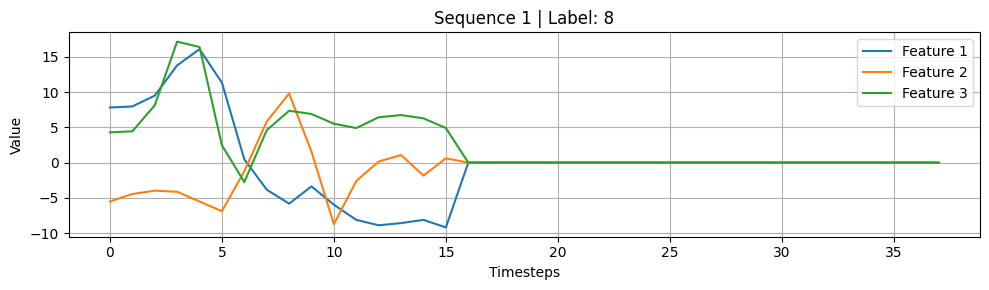

In [79]:
show_sequences(x,y)

32: The batch size (number of samples in the batch).
29: sequence length (number of timesteps in each sample).
3: The number of features per timestep (e.g., accelerometer and/or gyroscope axes like x, y, z).

In [65]:
input_channels = 3  # Number of input channels (e.g., x, y, z accelerometer data)
num_classes = 20 
datasets_params["GESTURES"]['link'] = "https://tev.fbk.eu/resources/smartwatch"
datasets_params["GESTURES"]['info'] = "GESTURES Time-Series data with x, y and z accelerometer data for 20 gestures"
datasets_params["GESTURES"]['num_classes'] = 20
datasets_params["GESTURES"]['input_channels'] = 3

In [80]:
flowerssetfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)
streamers = flowerssetfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()
x, y = next(iter(trainstreamer))
x.shape

2024-12-15 18:26:23.955 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\Francesca\.cache\mads_datasets\flowers


torch.Size([32, 3, 224, 224])

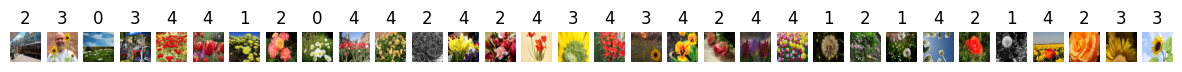

In [81]:
show_images(x, y)

- 32: The batch size (number of images in the batch).
- 3: The number of channels in each image, corresponding to the RGB color channels.
- 224: The height of each image in pixels.
- 224: The width of each image in pixels.

In [58]:
datasets_params["FLOWERS"]['link'] = "FLOWERS Image data, about 3000 large and complex images of 5 flowers"
datasets_params["FLOWERS"]['num_classes'] = 5
datasets_params["FLOWERS"]['input_channels'] = 3
datasets_params["FLOWERS"]['image_dim'] = (224,224)

In [59]:
fashionsetfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
streamers = fashionsetfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)


2024-12-15 18:14:59.769 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\Francesca\.cache\mads_datasets\fashionmnist
2024-12-15 18:14:59.770 | INFO     | mads_datasets.base:download_data:124 - File already exists at C:\Users\Francesca\.cache\mads_datasets\fashionmnist\fashionmnist.pt
C:\Users\Francesca\Documents\osint\code_repo\AI\MADS-MachineLearning-FP\.venv\lib\site-packages\mads_datasets\factories\torchfactories.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be a

In [61]:
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()
x, y = next(iter(trainstreamer))
x.shape

torch.Size([32, 1, 28, 28])

In [53]:
datasets_params["FASHION"]['info'] = 
datasets_params["FASHION"]['num_classes'] = 5
datasets_params["FASHION"]['input_channels'] = 1
datasets_params["FASHION"]['image_dim'] = (28,28)

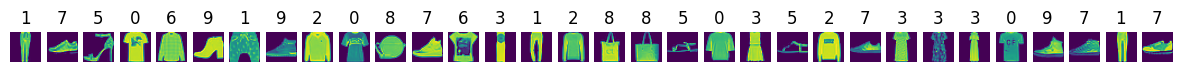

In [62]:
# Show images
show_images(x, y)

In [ ]:
#IMDB  Text data, 50k movie reviews with positive and negative sentiment labels
imbdsetfactory = DatasetFactoryProvider.create_factory(DatasetType.IMDB)
streamers = imbdsetfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)

In [ ]:
trainstreamer = train.stream()
validstreamer = valid.stream()
x, y = next(iter(trainstreamer))
x.shape

In [ ]:
datasets_params["IMDB"]['info'] = "Text data, 50k movie reviews with positive and negative sentiment labels"
datasets_params["IMDB"]['num_classes'] = 2
datasets_params["IMDB"]['input_channels'] = 1
datasets_params["IMDB"]['image_dim'] = ""

In [84]:
datasets_params

{'FLOWERS': {'link': 'FLOWERS Image data, about 3000 large and complex images of 5 flowers',
  'num_classes': 5,
  'input_channels': 3,
  'image_dim': (224, 224)},
 'IMDB': {},
 'GESTURES': {'link': 'https://tev.fbk.eu/resources/smartwatch',
  'num_classes': 20,
  'input_channels': 3,
  'info': 'GESTURES Time-Series data with x, y and z accelerometer data for 20 gestures'},
 'FASHION': {'info': 'FLOWERS Image data, about 3000 large and complex images of 5 flowers',
  'num_classes': 5,
  'input_channels': 1},
 'SUNSPOTS': {},
 'IRIS': {},
 'PENGUINS': {},
 'FAVORITA': {},
 'SECURE': {}}

In [ ]:
#IRIS dataset, 150 observations of 4 features of 3 iris flower species